In [1]:
#conda install xgboost

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, auc, log_loss
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, roc_curve

Since the pre-designated test dataset does not have include values for the target feature, the train dataset will be split further into a train/test set.

In [3]:
train = pd.read_csv('../data/Train.csv', index_col=0)
test = pd.read_csv('../data/Test.csv', index_col=0)

train.shape, test.shape

((13710, 41), (4570, 41))

In [4]:
train.dtypes

enrollee_id                          int64
city_development_index             float64
gender_Female                        int64
gender_Other                         int64
relevent_experience                  int64
enrolled_university_part_time        int64
enrolled_university_full_time        int64
education_level                      int64
major_STEM                           int64
major_Arts                           int64
major_Humanities                     int64
major_Business Degree                int64
major_No Major                       int64
major_Other                          int64
company_size                         int64
company_type_private_limited         int64
company_type_NGO                     int64
company_type_startup_funded          int64
company_type_public_sector           int64
company_type_startup_earlystage      int64
company_type_Other                   int64
last_new_job                         int64
training_hours                       int64
target     

In [5]:
train['target'] = train['target'].astype('int64')
test['target'] = test['target'].astype('int64')

In [6]:
# Split into test/train

X_train, y_train = train.drop(columns=['target', 'enrollee_id']), train.target
X_test, y_test = test.drop(columns=['target', 'enrollee_id']), test.target

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((13710, 39), (13710,), (4570, 39), (4570,))

In [7]:
# Scale Data

scaler = StandardScaler()

scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 0. Baseline Model

In [202]:
pd.DataFrame({
    'Counts':y_train.value_counts(),
    '%':y_train.value_counts()/len(y_train)
})

,Counts,%
0,10322,0.752881
1,3388,0.247119


As the majority response is 0 (most candidates are not looking for a job change), a baseline ZeroR classifier will be used as a basis of comparison for other models.

In [9]:
# Create a y_pred that is a series of 0s

from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train_scaled, y_train)
y_pred = dummy.predict(X_test_scaled)

print(classification_report(y_pred, y_test, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    1.00000   0.75274   0.85893      4570
           1    0.00000   0.00000   0.00000         0

    accuracy                        0.75274      4570
   macro avg    0.50000   0.37637   0.42946      4570
weighted avg    1.00000   0.75274   0.85893      4570



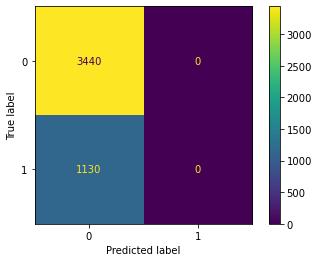

In [10]:
plot_confusion_matrix(dummy, X_test_scaled, y_test);

Baseline accuracy is 0.7527

# I. Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

In [11]:
LR = LogisticRegression(random_state=0)

LR.fit(X_train_scaled, y_train)
y_pred = LR.predict(X_test_scaled)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8144    0.9084    0.8589      3440
           1     0.5703    0.3699    0.4487      1130

    accuracy                         0.7753      4570
   macro avg     0.6923    0.6392    0.6538      4570
weighted avg     0.7541    0.7753    0.7575      4570



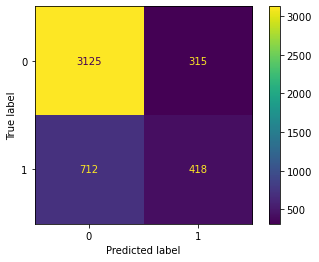

In [12]:
plot_confusion_matrix(LR, X_test_scaled, y_test);

This model performs somewhat better than the baseline. Next, I'll try to optimize performance with Grid Search cross validation

{0: 0.1, 1: 0.9}    41.684902
{0: 0.2, 1: 0.8}    66.411379
{0: 0.3, 1: 0.7}    75.842451
{0: 0.4, 1: 0.6}    77.549234
{0: 0.5, 1: 0.5}    77.527352
dtype: float64


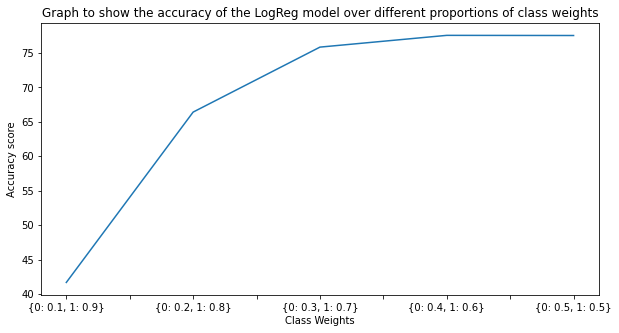

Wall time: 715 ms


In [212]:
%%time

# Print accuracy along different proportions of class weights

class_weight = [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}, {0: 0.5, 1: 0.5}]

acc = []

for i in class_weight:
    lm = LogisticRegression(class_weight=i, random_state=0)
    lm.fit(X_train_scaled, y_train)
    acc.append(accuracy_score(y_test, lm.predict(X_test_scaled)) * 100)
acc = pd.Series(acc, index=class_weight)

print(acc)
    
# Plot
plt.figure(figsize = (10,5))
plt.title('Graph to show the accuracy of the LogReg model over different proportions of class weights')
plt.xlabel('Class Weights')
plt.ylabel('Accuracy score')
acc.plot.line()
plt.show()

In [217]:
# Make pipeline
LR_pipeline = Pipeline([('scaler', StandardScaler()), ('LR', LogisticRegression())])

# Define parameters
params_LR = {
    'LR__C': [0.001, 0.1, 1, 10, 100],
    'LR__penalty': ['l2', 'l1',],
    'LR__solver': ['liblinear', 'saga'],
    'LR__class_weight': class_weight
}

In [218]:
%%time

gridcv_LR = GridSearchCV(LR_pipeline, param_grid=params_LR, cv=5, scoring='accuracy', verbose=10, n_jobs=-1)
gridcv_LR.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Wall time: 24.8 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('LR', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'LR__C': [0.001, 0.1, 1, 10, 100],
                         'LR__class_weight': [{0: 0.1, 1: 0.9},
                                              {0: 0.2, 1: 0.8},
                                              {0: 0.3, 1: 0.7},
                                              {0: 0.4, 1: 0.6},
                                              {0: 0.5, 1: 0.5}],
                         'LR__penalty': ['l2', 'l1'],
                         'LR__solver': ['liblinear', 'saga']},
             scoring='accuracy', verbose=10)

In [219]:
gridcv_LR.best_estimator_, gridcv_LR.best_params_, gridcv_LR.best_score_

(Pipeline(steps=[('scaler', StandardScaler()),
                 ('LR',
                  LogisticRegression(C=0.1, class_weight={0: 0.4, 1: 0.6},
                                     solver='liblinear'))]),
 {'LR__C': 0.1,
  'LR__class_weight': {0: 0.4, 1: 0.6},
  'LR__penalty': 'l2',
  'LR__solver': 'liblinear'},
 0.7835156819839534)

In [220]:
LR_best = gridcv_LR.best_estimator_

y_pred = LR_best.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8300    0.8817    0.8551      3440
           1     0.5557    0.4504    0.4976      1130

    accuracy                         0.7751      4570
   macro avg     0.6929    0.6661    0.6763      4570
weighted avg     0.7622    0.7751    0.7667      4570



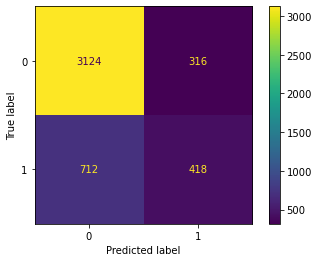

In [17]:
plot_confusion_matrix(LR_best, X_test, y_test);

The optimized logistic regression model performs about the same as the one with default settings.

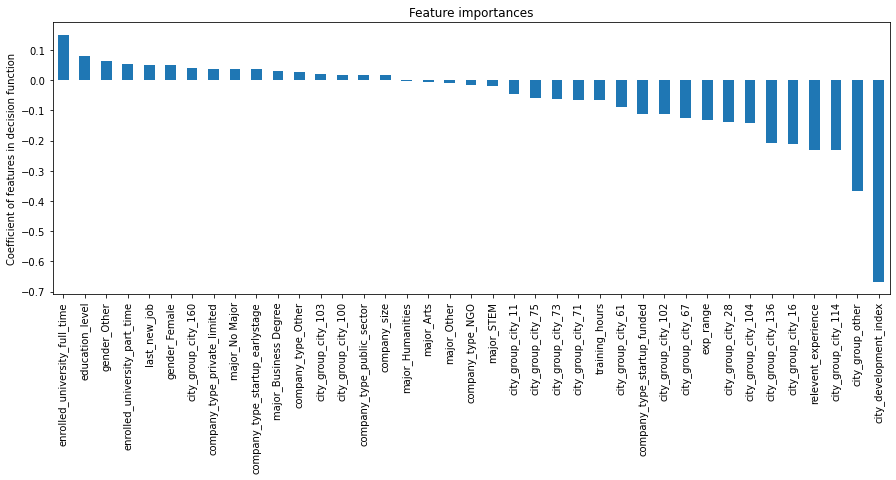

In [18]:
# Plot feature importance

importance = LR_best.named_steps.LR.coef_[0]
feat_imp = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15,5))
feat_imp.plot.bar(ax=ax)

ax.set_title("Feature importances")
ax.set_ylabel("Coefficient of features in decision function")
plt.xticks(rotation=90);

It seems nearly a third of the features have close to 0 impact in the model, though present enrollment and gender female/other seem to be strong predictors of a positive case

--------------------------------------------------------------------

# II. Random Forest Classifier

In [20]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(random_state=0)

RF.fit(X_train_scaled, y_train)
y_pred = RF.predict(X_test_scaled)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8099    0.8767    0.8420      3440
           1     0.4988    0.3735    0.4271      1130

    accuracy                         0.7523      4570
   macro avg     0.6543    0.6251    0.6346      4570
weighted avg     0.7330    0.7523    0.7394      4570



The default RF model performs slightly worse than the LogReg models.

{0: 0.1, 1: 0.9}    75.382932
{0: 0.2, 1: 0.8}    75.273523
{0: 0.3, 1: 0.7}    75.207877
{0: 0.4, 1: 0.6}    75.579869
{0: 0.5, 1: 0.5}    75.229759
dtype: float64


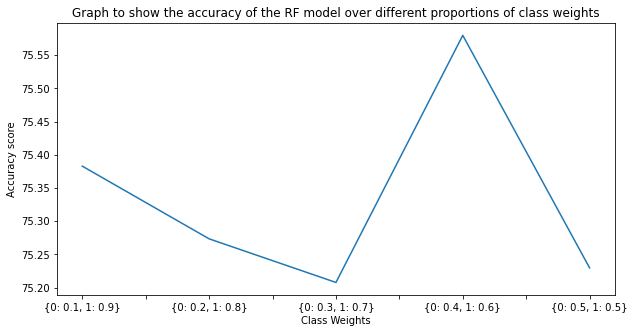

Wall time: 7.87 s


In [229]:
%%time

# Print accuracy along different proportions of class weights

class_weight = [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}, {0: 0.5, 1: 0.5}]

acc = []

for i in class_weight:
    clf = RandomForestClassifier(class_weight=i, random_state=0)
    clf.fit(X_train_scaled, y_train)
    acc.append(accuracy_score(y_test, clf.predict(X_test_scaled)) * 100)
acc = pd.Series(acc, index=class_weight)

print(acc)
    
# Plot
plt.figure(figsize = (10,5))
plt.title('Graph to show the accuracy of the RF model over different proportions of class weights')
plt.xlabel('Class Weights')
plt.ylabel('Accuracy score')
acc.plot.line()
plt.show()

It seems slightly under unbalanced (0.4 : 0.6) is optimal.

In [22]:
# Get a sense of the range of depths on default RF model

RF_depths = []

for i in range(len(RF.estimators_)):
    RF_depths.append(RF.estimators_[i].tree_.max_depth)
    
min(RF_depths), max(RF_depths)

(35, 50)

We can limit hyperparameter search to about this range of max depth.

In [230]:
# Make pipeline
RF_pipeline = Pipeline([('scaler', StandardScaler()), ('RF', RandomForestClassifier())])

# Define param grid
class_weight = [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}, {0: 0.5, 1: 0.5}]

params_RF = {
    'RF__n_estimators': [int(x) for x in np.linspace(start=100,stop=500,num=5)],
    'RF__max_depth': [10, 15, 20, 30, 50, 60], 
    #'RF__max_features': ['sqrt', 'log2', None], 
    #'RF__criterion': ['gini', 'entropy'],
    'RF__class_weight': class_weight
}

In [231]:
%%time

RF_gridcv = GridSearchCV(RF_pipeline, params_RF, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
RF_gridcv.fit(X_train, y_train)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
Wall time: 9min 28s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('RF', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'RF__class_weight': [{0: 0.1, 1: 0.9},
                                              {0: 0.2, 1: 0.8},
                                              {0: 0.3, 1: 0.7},
                                              {0: 0.4, 1: 0.6},
                                              {0: 0.5, 1: 0.5}],
                         'RF__max_depth': [10, 15, 20, 30, 50, 60],
                         'RF__n_estimators': [100, 200, 300, 400, 500]},
             scoring='accuracy', verbose=2)

In [232]:
RF_gridcv.best_estimator_, RF_gridcv.best_params_, RF_gridcv.best_score_

(Pipeline(steps=[('scaler', StandardScaler()),
                 ('RF',
                  RandomForestClassifier(class_weight={0: 0.4, 1: 0.6},
                                         max_depth=10, n_estimators=500))]),
 {'RF__class_weight': {0: 0.4, 1: 0.6},
  'RF__max_depth': 10,
  'RF__n_estimators': 500},
 0.7887673231218089)

In [233]:
RF_best = RF_gridcv.best_estimator_

y_pred = RF_best.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8412    0.8776    0.8590      3440
           1     0.5708    0.4956    0.5306      1130

    accuracy                         0.7832      4570
   macro avg     0.7060    0.6866    0.6948      4570
weighted avg     0.7743    0.7832    0.7778      4570



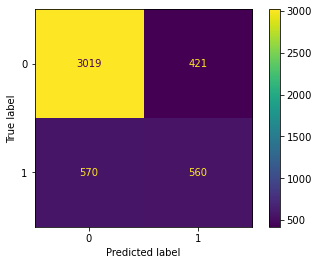

In [235]:
plot_confusion_matrix(RF_best, X_test, y_test);

The tuned model is definitely better than the default RF!

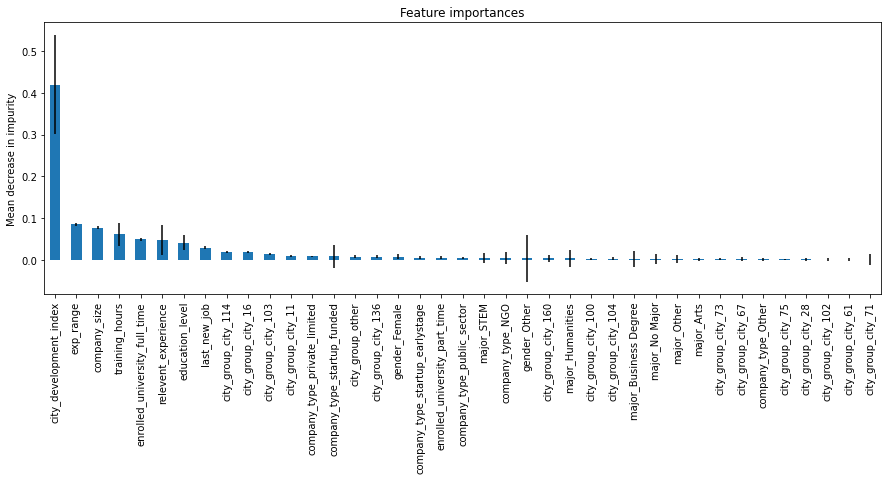

In [236]:
# Viewing feature importances

importance = RF_best.named_steps.RF.feature_importances_
forest_imp = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)
std = np.std([tree.feature_importances_ for tree in RF_best.named_steps.RF.estimators_], axis=0)

# Plot
fig, ax = plt.subplots(figsize=(15,5))

forest_imp.plot.bar(yerr=std, ax=ax)

ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
plt.xticks(rotation=90);

# III. Support Vector Machine

### a) Linear SVC

In [68]:
from sklearn.svm import LinearSVC

In [244]:
# Define param grid
class_weight = [{0: 0.1, 1: 0.9}, {0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}, {0: 0.5, 1: 0.5}]

params_SVC_lin = {
    'SVC_Linear__C': [0.01, 0.1, 1, 10, 100, 1000],
    'SVC_Linear__class_weight': class_weight,
    'SVC_Linear__max_iter': [int(x) for x in np.linspace(start=100,stop=500,num=5)],
    #'SVC_Linear__dual': [False]
}

In [91]:
%%time

# Grid search for optimal hyperparameters

SVC_linear = Pipeline([('scaler', StandardScaler()), ('SVC_Linear', LinearSVC(dual=False, random_state=0))])

SVC_lin_gridcv = GridSearchCV(SVC_linear, params_SVC_lin, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
SVC_lin_gridcv.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('SVC_Linear', LinearSVC())]),
             n_jobs=-1,
             param_grid={'SVC_Linear__C': [0.1, 1, 10, 100, 1000],
                         'SVC_Linear__class_weight': ['balanced', None],
                         'SVC_Linear__dual': [False],
                         'SVC_Linear__max_iter': [100, 200, 300, 400, 500]},
             scoring='accuracy', verbose=2)

In [92]:
SVC_lin_gridcv.best_estimator_, SVC_lin_gridcv.best_params_, SVC_lin_gridcv.best_score_

(Pipeline(steps=[('scaler', StandardScaler()),
                 ('SVC_Linear', LinearSVC(C=0.1, dual=False, max_iter=100))]),
 {'SVC_Linear__C': 0.1,
  'SVC_Linear__class_weight': None,
  'SVC_Linear__dual': False,
  'SVC_Linear__max_iter': 100},
 0.7835156819839533)

In [93]:
SVC_linear_best = SVC_lin_gridcv.best_estimator_

y_pred = SVC_linear_best.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8166    0.9087    0.8602      3440
           1     0.5768    0.3788    0.4573      1130

    accuracy                         0.7777      4570
   macro avg     0.6967    0.6437    0.6587      4570
weighted avg     0.7573    0.7777    0.7606      4570



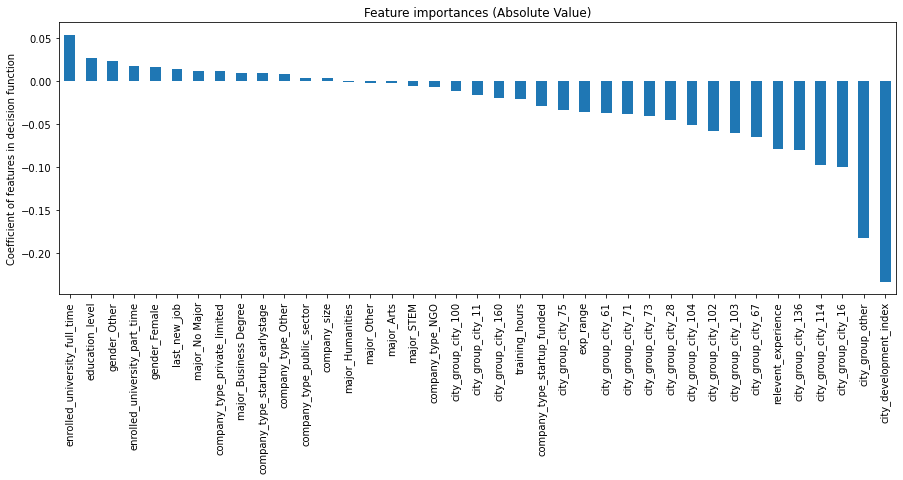

In [179]:
# Plot feature importance

importance = SVC_linear_best.named_steps.SVC_Linear.coef_[0]
feat_imp = pd.Series(importance, index=X_train.columns).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(15,5))
feat_imp.plot.bar(ax=ax)

ax.set_title("Feature importances (Absolute Value)")
ax.set_ylabel("Coefficient of features in decision function")
plt.xticks(rotation=90);

City groups seem to be the most influential predictors

### b) SVC (nonlinear kernels)

In [ ]:
from sklearn.svm import SVC

In [264]:
%%time

# Print accuracy for different kernel types (with default params)

kernels = ['linear', 'rbf', 'poly', 'sigmoid']

acc = []

for i in kernels:
    svc = SVC(kernel=i, random_state=0)
    svc.fit(X_train_scaled, y_train)
    acc.append(accuracy_score(y_test, svc.predict(X_test_scaled)) * 100)
acc = pd.Series(acc, index=kernels)

print(acc)

linear     77.986871
rbf        77.943107
poly       77.111597
sigmoid    71.050328
dtype: float64
Wall time: 40.4 s


It seems we can skip hyperparameter tuning over sigmoid kernel.

0.01     75.273523
0.10     77.702407
0.50     77.964989
1.00     77.943107
2.00     77.921225
5.00     77.768053
10.00    77.680525
dtype: float64


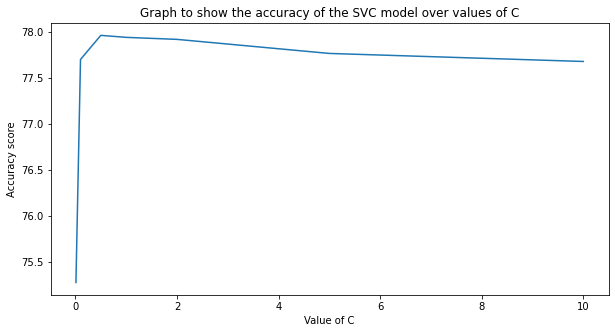

Wall time: 1min 34s


In [265]:
%%time

# Print accuracy along different values of c
c_range = [0.01, 0.1, 0.5, 1, 2, 5, 10]
acc = []

for i in c_range:
    svc = SVC(C=i, random_state=0)
    svc.fit(X_train_scaled, y_train)
    acc.append(accuracy_score(y_test, svc.predict(X_test_scaled)) * 100)
acc = pd.Series(acc, index=c_range)

print(acc)
    
# Plot
plt.figure(figsize = (10,5))
plt.title('Graph to show the accuracy of the SVC model over values of C')
plt.xlabel('Value of C')
plt.ylabel('Accuracy score')
acc.plot.line()
plt.show()

It appears the optimal value of c is 1, though accuracy doesn't vary by much.

In [258]:
# Make pipeline
SVC_nonlinear = Pipeline([('scaler', StandardScaler()), ('SVC', SVC(random_state=0))])

# Define param grid
class_weight = [{0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}, {0: 0.5, 1: 0.5}]

params_SVC_rbf = {
    'SVC__kernel': ['rbf'], 
    'SVC__C': [0.1, 0.5, 1, 2, 5],
    'SVC__gamma': [.0001, .001, .01, 1, 10],
    'SVC__class_weight': class_weight
}

In [259]:
%%time

# Grid search
SVC_rbf_gridcv = GridSearchCV(SVC_nonlinear, params_SVC_rbf, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
SVC_rbf_gridcv.fit(X_train, y_train)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Wall time: 46min 24s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('SVC', SVC(random_state=0))]),
             n_jobs=-1,
             param_grid={'SVC__C': [0.1, 0.5, 1, 2, 5, 10],
                         'SVC__class_weight': [{0: 0.2, 1: 0.8},
                                               {0: 0.3, 1: 0.7},
                                               {0: 0.4, 1: 0.6},
                                               {0: 0.5, 1: 0.5}],
                         'SVC__gamma': [0.0001, 0.001, 0.01, 1, 10],
                         'SVC__kernel': ['rbf']},
             scoring='accuracy', verbose=2)

In [260]:
SVC_rbf_gridcv.best_estimator_, SVC_rbf_gridcv.best_params_, SVC_rbf_gridcv.best_score_

(Pipeline(steps=[('scaler', StandardScaler()),
                 ('SVC',
                  SVC(C=2, class_weight={0: 0.4, 1: 0.6}, gamma=0.001,
                      random_state=0))]),
 {'SVC__C': 2,
  'SVC__class_weight': {0: 0.4, 1: 0.6},
  'SVC__gamma': 0.001,
  'SVC__kernel': 'rbf'},
 0.7850474106491612)

In [261]:
SVC_rbf_best = SVC_rbf_gridcv.best_estimator_

y_pred = SVC_rbf_best.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.8263    0.8977    0.8605      3440
           1     0.5774    0.4257    0.4901      1130

    accuracy                         0.7810      4570
   macro avg     0.7019    0.6617    0.6753      4570
weighted avg     0.7648    0.7810    0.7689      4570



In [ ]:
%%time

# Print accuracy along different values of degree

degree = [0, 1, 2, 3, 4, 5, 6]

acc = []

for i in degree:
    svc = SVC(kernel='poly', degree=i, random_state=0)
    svc.fit(X_train_scaled, y_train)
    acc.append(accuracy_score(y_test, svc.predict(X_test_scaled)) * 100)
acc = pd.Series(acc, index=degree)

print(acc)
    
# Plot
plt.figure(figsize = (10,5))
plt.title('Graph to show the accuracy of poly SVC model over values of degree')
plt.xlabel('Degree')
plt.ylabel('Accuracy score')
acc.plot.line()
plt.show()

In [ ]:
%%time

params_SVC_poly = {
    'SVC__kernel': ['poly'], 
    'SVC__C': [0.1, 0.5, 1, 2, 5],
    'SVC__gamma': [.0001, .001, .01, 1, 10],
    'SVC__class_weight': class_weight,
    'SVC__degree': [0, 1, 2, 3, 4] #When kernel = poly
}

# Grid search
SVC_poly_gridcv = GridSearchCV(SVC_nonlinear, params_SVC_poly, cv=5, scoring='accuracy', verbose=2, n_jobs=-1)
SVC_poly_gridcv.fit(X_train, y_train)

In [ ]:
SVC_poly_gridcv.best_estimator_, SVC_poly_gridcv.best_params_, SVC_poly_gridcv.best_score_

In [ ]:
SVC_poly_best = SVC_poly_gridcv.best_estimator_

y_pred = SVC_poly_best.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))

# IV. XGBoost Model

In [31]:
%%time

import xgboost as xgb

XGB = xgb.XGBClassifier(objective='binary:logistic', use_label_encoder=False, random_state=0)

XGB.fit(X_train_scaled, y_train)
y_pred = XGB.predict(X_test_scaled)

print(classification_report(y_test, y_pred, digits=4))

[10:03:38] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0     0.8204    0.8831    0.8506      3440
           1     0.5363    0.4115    0.4657      1130

    accuracy                         0.7665      4570
   macro avg     0.6784    0.6473    0.6582      4570
weighted avg     0.7502    0.7665    0.7554      4570

Wall time: 695 ms


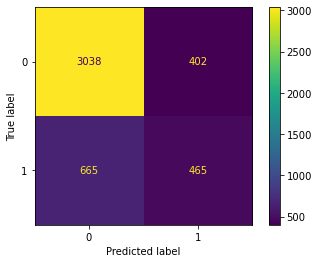

In [32]:
plot_confusion_matrix(XGB, X_test_scaled, y_test);

The default xgb model performs only slightly better than the baseline dummy model.

# V. Select Best Model

In [266]:
models = [
    ('Dummy (Baseline)', dummy),
    ('LogReg', LR),
    ('LogReg_best', LR_best), 
    ('RandomForest', RF),
    ('RandomForest_best', RF_best),
    ('SVC_Linear', SVC_linear_best),
    ('SVC_RBF', SVC_rbf_best),
    #('SVC_Poly', SVC_poly_best),
    ('XGB', XGB),
    #('XGB_best', GB_best)
]

scoring = ['precision', 'recall', 'accuracy', 'f1', 'roc_auc']

NameError: name 'SVC_rbf_best' is not defined

In [ ]:
%%time
%%capture --no-display

results= {}
for name, model in models:
    results[name] = {}
    for i in scoring:        
        scores = cross_validate(model, X_train, y_train, scoring=i, cv=5, return_train_score=True)
        results[name][i] = scores

In [267]:
Precision_Train = []
Precision_Test = []
Recall_Train = []
Recall_Test = []
Accuracy_Train = []
Accuracy_Test = []
F1_Train = []
F1_Test = []
AUC_Train = []
AUC_Test = []

for model in results.keys():
    # Precision
    pr_train_mean = results[model]['precision']['train_score'].mean()*100
    pr_test_mean = results[model]['precision']['test_score'].mean()*100
    Precision_Train.append(round(pr_train_mean, 2))
    Precision_Test.append(round(pr_test_mean, 2))
    
    # Recall
    rec_train_mean = results[model]['recall']['train_score'].mean()*100
    rec_test_mean = results[model]['recall']['test_score'].mean()*100
    Recall_Train.append(round(rec_train_mean, 2))
    Recall_Test.append(round(rec_test_mean, 2))
    
    # Accuracy
    acc_train_mean = results[model]['accuracy']['train_score'].mean()*100
    acc_test_mean = results[model]['accuracy']['test_score'].mean()*100
    Accuracy_Train.append(round(acc_train_mean, 2))
    Accuracy_Test.append(round(acc_test_mean, 2))
    
    # F1
    f1_train_mean = results[model]['f1']['train_score'].mean()*100
    f1_test_mean = results[model]['f1']['test_score'].mean()*100
    F1_Train.append(round(f1_train_mean, 2))
    F1_Test.append(round(f1_test_mean, 2))
    
    # AUC
    auc_train_mean = results[model]['roc_auc']['train_score'].mean()
    auc_test_mean = results[model]['roc_auc']['test_score'].mean()
    AUC_Train.append(round(auc_train_mean, 4))
    AUC_Test.append(round(auc_test_mean, 4))
    
# Save model names and parameters as list
names = []
steps = []
for name, model in models:
    names.append(str(name))
    if hasattr(model, 'named_steps'):
        steps.append(str(list(model.named_steps.values())[1]))
    else:
        steps.append(model)

In [268]:
#pd.options.display.max_colwidth = 100

model_compare = pd.DataFrame(
    {'Model': names,
#     'Precision_Train': Precision_Train,
     'Precision_Test': Precision_Test,
#     'Recall_Train': Recall_Train,
     'Recall_Test': Recall_Test,
     'Acc_Train': Accuracy_Train,
     'Acc_Test': Accuracy_Test,
#     'F1_Train': F1_Train,
     'F1_Test': F1_Test,
#     'AUC_Train': AUC_Train,
     'AUC_Test': AUC_Test,
     #'Parameters': steps
    }
)

model_compare

,Model,Precision_Test,Recall_Test,Acc_Train,Acc_Test,F1_Test,AUC_Test
0,Dummy (Baseline),0.00,0.00,75.29,75.29,0.00,0.5000
1,LogReg,60.25,24.91,77.36,77.40,34.96,0.7441
2,LogReg_best,60.20,36.22,78.42,78.30,45.22,0.7549
3,RandomForest,54.08,38.75,99.70,76.75,45.12,0.7498
4,RandomForest_best,57.80,47.05,83.05,78.32,51.71,0.7801
5,SVC_Linear,60.08,37.16,78.35,78.35,45.91,0.7548
6,SVC_Nonlinear,59.94,37.46,78.92,78.34,46.09,0.7332
7,XGB,55.65,40.94,87.03,77.35,47.16,0.7710
